<a href="https://colab.research.google.com/github/vhymathias/data-science/blob/main/Bike_sharing_An%C3%A1lise_explorat%C3%B3ria_e_Regress%C3%A3o_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.1 Importando bibliotecas e dados

In [1]:
!git clone https://github.com/vhymathias/data-science.git

Cloning into 'data-science'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [2]:
!pip install plotly --upgrade

     |████████████████████████████████| 25.3 MB 1.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px

df = pd.read_csv('/content/data-science/datasets/bike-sharing/day.csv')

weathersit_map = {1: 'Clear',2: 'Mist', 3: 'Formations - Light', 4: 'Formations - Heavy'}
df['weathersit_num'] = df['weathersit']
df['weathersit'] = df['weathersit'].apply(lambda x: str(x)+" _ "+weathersit_map[x])

season_map = {1: 'winter',2: 'spring', 3: 'summer', 4: 'autumn'}
df['season_num'] = df['season']
df['season'] = df['season'].apply(lambda x: str(x)+"_"+season_map[x])

df['weekday_num'] = df['weekday'] 
weekday_map = {
    0: 'sunday',
    1: 'monday',
    2: 'tuesday',
    3: 'wednesday',
    4: 'thursday',
    5: 'friday',
    6: 'saturday'
}
df['weekday'] = df['weekday'].apply(lambda x: str(x)+"_"+weekday_map[x])

df['workingday_num'] = df['workingday']
df['workingday'] = df['workingday'].apply(lambda x : 'workday' if x == 1 else 'restday')

df['yr_str'] = df['yr'].apply(lambda x: 2012 if x == 1 else 2011)

df['yr_month'] = df.apply(lambda x : str(x['yr_str'])+"_"+"{:02d}".format(x['mnth']),axis=1)

df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weathersit_num,season_num,weekday_num,workingday_num,yr_str,yr_month
0,1,2011-01-01,1_winter,0,1,0,6_saturday,restday,2 _ Mist,0.344167,0.363625,0.805833,0.160446,331,654,985,2,1,6,0,2011,2011_01
1,2,2011-01-02,1_winter,0,1,0,0_sunday,restday,2 _ Mist,0.363478,0.353739,0.696087,0.248539,131,670,801,2,1,0,0,2011,2011_01
2,3,2011-01-03,1_winter,0,1,0,1_monday,workday,1 _ Clear,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1,1,1,1,2011,2011_01
3,4,2011-01-04,1_winter,0,1,0,2_tuesday,workday,1 _ Clear,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1,1,2,1,2011,2011_01
4,5,2011-01-05,1_winter,0,1,0,3_wednesday,workday,1 _ Clear,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1,1,3,1,2011,2011_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1_winter,1,12,0,4_thursday,workday,2 _ Mist,0.254167,0.226642,0.652917,0.350133,247,1867,2114,2,1,4,1,2012,2012_12
727,728,2012-12-28,1_winter,1,12,0,5_friday,workday,2 _ Mist,0.253333,0.255046,0.590000,0.155471,644,2451,3095,2,1,5,1,2012,2012_12
728,729,2012-12-29,1_winter,1,12,0,6_saturday,restday,2 _ Mist,0.253333,0.242400,0.752917,0.124383,159,1182,1341,2,1,6,0,2012,2012_12
729,730,2012-12-30,1_winter,1,12,0,0_sunday,restday,1 _ Clear,0.255833,0.231700,0.483333,0.350754,364,1432,1796,1,1,0,0,2012,2012_12


# 0.2 Sobre o dataset
Este dataset representa métricas sobre um serviço de compartilhamento de bicicletas (bike sharing). Os dados foram coletados em Washington DC, entre 2011 e 2012.

As variáveis disponíveis significam:
- instant: record index
- dteday : data
- season : estação (1: inverno, 2:primavera, 3:verão, 4:Outono)
	- yr : ano (0: 2011, 1:2012)
	- mnth : mês ( 1 to 12)
- holiday : se o dia é feriado ou não (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : dia da semana (começa em 0 - domingo)
- workingday : se dia é de trabalho / útil
- weathersit: 
	- 1: Céu limpo, poucas nuvens
	- 2: Neblina, céu fechado
	- 3: Neve, chuva leve
	- 4: Neve, chuva pesada
- temp : Temperatura normalizada em Celsius. Valores divididos por 41 (max)
- atemp: Sensação térmica normalizada em Celsius. Valores divididos por 50 (max)
- hum: Umidade normalizada. Os valores são divididos por 100 (max)
- windspeed: Velocidade do vento normalizada. Os valores são divididos por 67 (max)
- casual: Contagem de usuários casuais
- registered: Contagem de usuários registrados
- cnt: Contagem do total de usuários
	

#1.Análise exploratória

##1.1 Dia de trabalho vs dia de descanso

Ao comparar dia de trabalho vs dia de descanso, é possível ver que eles possuem um número de usuário similar por dia.

In [4]:
#@title
grouped_data = df[['workingday', 'cnt']].groupby(['workingday'])['cnt'].agg([np.sum,"count"]).reset_index()
grouped_data['user/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
print(grouped_data)
fig = px.bar(grouped_data, x='workingday', y='user/day', color = 'workingday', text = 'user/day', width=800)
fig.update_layout(
    title={
        'text': "workingday vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

  workingday      sum  count  user/day
0    restday  1000269    231   4330.17
1    workday  2292410    500   4584.82


Entrando no detalhe, é possível entender melhor o comportamento de cada tipo de usuário (casual e registrado) dependendo do tipo de dia. Os usuários casuais dão preferência para alugar a bicicleta em dias de descanso, já os usuários registrados acabam usando mais nos dias úteis.

In [5]:
#@title
main_var = 'workingday'
grouped_data = df[[main_var, 'casual','registered']].groupby([main_var])[['casual','registered']].agg([np.sum,"count"])
grouped_data = grouped_data.stack(0).reset_index().rename(columns={'level_1': 'type'})
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='type', y='users/day', color = 'workingday', text = 'users/day', width=800, barmode='group')
fig.update_layout(
    title={
        'text': "user type vs workingday vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

##1.2 Dia da semana

Ao entrarmos no detalhe do dia da semana, temos um comportamento bem similar ao análise em dia de descanso vs dia de trabalho: na média, os números são similares, e comparando tipos de usuário, o registrado prefere os dias de semana, e os casuais os fim de semana.

In [6]:
#@title

grouped_data = df[['weekday', 'cnt']].groupby(['weekday'])['cnt'].agg([np.sum,"count"]).reset_index()
grouped_data['user/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='weekday', y='user/day', color = 'weekday', text = 'user/day', width=800)
fig.update_layout(
    title={
        'text': "weekday vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()


In [7]:
#@title
main_var = 'weekday'
grouped_data = df[[main_var, 'casual','registered']].groupby([main_var])[['casual','registered']].agg([np.sum,"count"])
grouped_data = grouped_data.stack(0).reset_index().rename(columns={'level_1': 'type'})
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='type', y='users/day', color = 'weekday', text = 'users/day', width=800, barmode='group')
fig.update_layout(
    title={
        'text': "user type vs weekday vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

##1.3 Seasons
Ao comparar as estações, fica bem claro que o número de usuários cai bastante durante o inverno. É possível que isso se deva ao clima mais extremo que se dá nessa estação, de muito frio.

In [8]:
#@title
grouped_data = df[['season', 'cnt']].groupby(['season'])['cnt'].agg([np.sum,"count"]).reset_index()
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='season', y='users/day', color = 'season', text = 'users/day', width=800)
fig.update_layout(
    title={
        'text': "season vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

Entrando no detalhe, é possível entender melhor o comportamento de cada tipo de usuário (casual e registrado) dependendo da estação. O inverno tem pouco resultado para ambos os casos, mas para os casuais, o número de usuários por dia sofre queda no outono também.

In [9]:
#@title
main_var = 'season'
grouped_data = df[[main_var, 'casual','registered']].groupby([main_var])[['casual','registered']].agg([np.sum,"count"])
grouped_data = grouped_data.stack(0).reset_index().rename(columns={'level_1': 'type'})
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='type', y='users/day', color = main_var, text = 'users/day', width=1000, barmode='group')
fig.update_layout(
    title={
        'text': "user type vs season vs users/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

Outro ângulo para análise possível é entender qual o impacto da estação na variação de usuários/dia entre dias úteis e dias de descanso.

In [10]:
#@title
grouped_data = df[['season','workingday', 'casual','registered']].groupby(['season','workingday'])[['casual','registered']].agg([np.sum,"count"])
grouped_data = grouped_data.stack(0).reset_index().rename(columns={'level_2': 'type'})

grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
grouped_data = grouped_data.pivot(index=['type', 'season'],columns='workingday',values='users/day').reset_index()

Como anteriormente pontuado, para usuários casuais, há um aumento de usuários/dia do dia útil para o dia de descanso, calculado por 
> (var_restday-var_workday)/var_workday

Como é possível ver abaixo, o menor impacto é no verão, e o maior no outono

In [11]:
#@title
casual_grouped_data = grouped_data[grouped_data['type']=='casual'][['season','workday','restday']]
casual_grouped_data['restday increase'] = grouped_data.apply(lambda x: "{:.2%}".format((x['restday'] - x['workday'])/x['workday']),axis=1)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4],
    columnwidth = [50]*4,
    header=dict(values=list(casual_grouped_data.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=casual_grouped_data.values.T,
               fill_color='lavender',
               align='left'),
)
])
fig.update_layout(width=600, height=120, margin=dict(r=5, l=5, t=5, b=5))
fig.show()

Já para usuários registrados, há uma diminuição de usuários/dia do dia útil para o dia de descanso, calculado por 
> (var_restday-var_workday)/var_workday

No caso dos registrados, a diferença entre os dias depende menos da estação

In [12]:
#@title
registered_grouped_data = grouped_data[grouped_data['type']=='registered'][['season','workday','restday']]
registered_grouped_data['restday decrease'] = grouped_data.apply(lambda x: "{:.2%}".format((x['restday'] - x['workday'])/x['workday']),axis=1)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4],
    columnwidth = [50]*4,
    header=dict(values=list(registered_grouped_data.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=registered_grouped_data.values.T,
               fill_color='lavender',
               align='left'),
)
])
fig.update_layout(width=600, height=120, margin=dict(r=5, l=5, t=5, b=5))
fig.show()

##1.4 Weather Situation
A variável weather situation busca representar o clima do dia, classificando em Clear (céu limpo/aberto), Mist (céu com névoa) e Formations (formações no céu, como chuva ou afins), sendo Light (leve) ou Heavy (pesado). Fica claro no gráfico abaixo que tipo de clima atrai mais os usuários.

In [13]:
#@title
grouped_data = df[['weathersit', 'cnt']].groupby(['weathersit'])['cnt'].agg([np.sum,"count"]).reset_index()
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='weathersit', y='users/day', color = 'weathersit', text = 'users/day', width=800)
fig.update_layout(
    title={
        'text': "Weather situation vs users/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

Entrando no detalhe, é possível entender melhor o comportamento de cada tipo de usuário (casual e registrado) dependendo da situação do tempo. As diferenças entre as situações são similares para ambos os tipos de usuário.

In [14]:
#@title
main_var = 'weathersit'
grouped_data = df[[main_var, 'casual','registered']].groupby([main_var])[['casual','registered']].agg([np.sum,"count"])
grouped_data = grouped_data.stack(0).reset_index().rename(columns={'level_1': 'type'})
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='type', y='users/day', color = main_var, text = 'users/day', width=1000, barmode='group')
fig.update_layout(
    title={
        'text': "user type vs weather situation vs users/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

##1.5 Crescimento no tempo
Quando comparamos o número de usuários/dia, mês a mês, nos dois anos do dataset, é possível perceber um rápido crescimento 2012 vs 2011, tanto para os usuários registrados como os casuais. É interessante notar também que em ambos os anos, para ambos os tipos de usuários, conseguimos ver um número maior nos meses do verão, e menor nos meses de inverno (considerando o hemisfério norte)

In [15]:
#@title
main_var = 'yr_month'
grouped_data = df[[main_var, 'casual','registered']].groupby([main_var])[['casual','registered']].agg([np.sum,"count"])
grouped_data = grouped_data.stack(0).reset_index().rename(columns={'level_1': 'type'})
grouped_data['users/day'] = grouped_data.apply(lambda x : float("{:.2f}".format(x['sum']/x['count'])),axis=1)
fig = px.bar(grouped_data, x='yr_month', y='users/day', color = 'type', text = 'users/day', width=1300, height=500, barmode='group')
fig.update_layout(
    title={
        'text': "yr_month vs user type vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.add_vline(x=11.5)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside',constraintext='none')
fig.update_traces(outsidetextfont=dict(size=10))
fig.show()

##1.6 Variáveis contínuas
No dataset, temos algumas variáveis contínuas, normalizadas:


*   <b>temp</b>: temperatura registrada (normalizada com máximo de 41°C)
*   <b>atemp</b>: sensação térmica registrada (normalizada com máximo de 50°C)
*   <b>hum</b>: nível de umidade registrada (normalizada com máximo de 100%)
*   <b>windspeed</b>: velocidade do vento registrada (normalizada com máximo de 67)

Abaixo, temos gráficos de dispersão para cada variável, com cada ponto sendo um dia, registrando o valor da variável versus o valor total de usuários. É possível perceber que temp e atemp têm um comportamento quadrático, com valor máximo próximo a 0.6 normalizado (temp 24,6°C e atemp 30°C).












In [16]:
#@title
columns = ['temp','atemp','hum','windspeed']
new_df_columns = []

df[columns + ['cnt']].apply(lambda row: new_df_columns.extend([{'var':column,'value':row[column],'cnt':row['cnt']} for column in columns]), axis =1)

new_df = pd.DataFrame(new_df_columns)

fig = px.scatter(new_df, x='value', y='cnt', facet_col ='var', facet_col_wrap = 2, color='var', width= 1200)
fig.update_layout(
    title={
        'text': "climate variables vs user count",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

Abaixo, as variáveis contínuas foram quebradas em 20 bins, para avaliação. Na parte de cima, temos no eixo y a quantidade de usuários por dia (users/day) e na parte de baixo, um gráfico de histograma, contando o número de pontos/dias que entram em cada bin. 

Quanto à variável temp, é possível ver números maiores a partir dos 20,5°C, atingindo o máximo entre 25°C e 30°C aproximadamente. Para sensação térmica (atemp), temos um comportamento similar, com números maiores a partir de 27,5°C, atingindo o máximo entre 30°C e 35°C.

Em ambas as variáveis, é possível perceber que a partir de 34,8°C (temp) e 42,5°C (atemp), os números voltam a cair, indicando que, nesses intervalos, as temperaturas ficam acima do ideal na concepção dos usuários.

In [17]:
#@title
columns = ['temp','atemp','hum','windspeed']
multipliers = {'temp':41,'atemp':50,'hum':100,'windspeed':67}
dfs_for_each_var = {}
traces = []
import plotly.graph_objects as go
from plotly.subplots import make_subplots
for column in columns:
    aux_df = df.copy()
    aux_df[column+'_cut'] = pd.cut(aux_df[column],bins=[i/20 for i in range(0,21)])
    hist_values = aux_df[column+'_cut'].value_counts().sort_index().values
    aux_df = aux_df[[column+'_cut', 'cnt']].groupby(column+"_cut")['cnt'].agg(['sum','count']).reset_index()
    aux_df['users/day'] = aux_df.apply(lambda row : float("{:.2f}".format(row['sum']/row['count'])) if row['count']>0 else 0, axis = 1)
    aux_df[column+'_cut'] = aux_df[column+'_cut'].astype(str)
    x_labels = aux_df[column+'_cut'].apply(lambda x: x.split(", ")[-1].replace("]","")).apply(lambda x: float(x)*multipliers[column]).apply(lambda x: "{:.2f}".format(x))
    traces.append(go.Bar(x=x_labels, y=aux_df['users/day'], text = aux_df['users/day'],name=column))#+" (users/day)"))
    traces.append(go.Bar(x=x_labels, y=hist_values, text = hist_values,name=None))#+" (histogram)"))
    
fig = make_subplots(rows=2,cols=2, subplot_titles = [traces[i]['name'] for i in [0,2,1,3]],vertical_spacing=0.03)
fig.append_trace(traces[0],1,1)
fig.append_trace(traces[1],2,1)
fig.append_trace(traces[2],1,2)
fig.append_trace(traces[3],2,2)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "Continuous vars vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
yaxes = ["users/day","users/day","#days","#days"]
for i in range(4):
  if yaxes[i] == "users/day":
    fig['layout']['xaxis'+str(i+1)]['visible'] = False
  fig['layout']['yaxis'+str(i+1)]['title'] = yaxes[i]

fig.update_traces(texttemplate='%{text:.2s}')
fig.show()

De forma análoga, os usuários preferem a umidade entre 60% e 70%, e a velocidade do vento em torno de 13.

In [18]:
#@title
fig = make_subplots(rows=2,cols=2, subplot_titles = [traces[i]['name'] for i in [4,6,5,7]],vertical_spacing=0.03)
fig.append_trace(traces[4],1,1)
fig.append_trace(traces[5],2,1)
fig.append_trace(traces[6],1,2)
fig.append_trace(traces[7],2,2)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "Continuous vars vs user/day",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
yaxes = ["users/day","users/day","#days","#days"]
for i in range(4):
  if yaxes[i] == "users/day":
    fig['layout']['xaxis'+str(i+1)]['visible'] = False
  fig['layout']['yaxis'+str(i+1)]['title'] = yaxes[i]

fig.update_traces(texttemplate='%{text:.2s}')
fig.show()


##1.6a Variáveis contínuas (apenas usuários casuais)
No dataset, temos algumas variáveis contínuas, normalizadas:


*   <b>temp</b>: temperatura registrada (normalizada com máximo de 41°C)
*   <b>atemp</b>: sensação térmica registrada (normalizada com máximo de 50°C)
*   <b>hum</b>: nível de umidade registrada (normalizada com máximo de 100%)
*   <b>windspeed</b>: velocidade do vento registrada (normalizada com máximo de 67)

Quando olhamos os dados filtrados apenas para usuários casuais, os gráficos de dispersão ficam mais complexos de se interpretar. Focaremos por enquanto nos gráficos de bins.











In [19]:
#@title
columns = ['temp','atemp','hum','windspeed']
new_df_columns = []

df[columns + ['casual']].apply(lambda row: new_df_columns.extend([{'var':column,'value':row[column],'casual':row['casual']} for column in columns]), axis =1)

new_df = pd.DataFrame(new_df_columns)

fig = px.scatter(new_df, x='value', y='casual', facet_col ='var', facet_col_wrap = 2, color='var', width= 1200)
fig.update_layout(
    title={
        'text': "climate variables vs user count (casual)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

Em relação aos gráficos quebrados em bins, vemos muitas semelhanças do comportamento dos usuários casuais comparados ao total, inclusive nas faixas de preferência em que o número de usuários cresce significativamente.

In [20]:
#@title
columns = ['temp','atemp','hum','windspeed']
multipliers = {'temp':41,'atemp':50,'hum':100,'windspeed':67}
dfs_for_each_var = {}
traces = []
import plotly.graph_objects as go
from plotly.subplots import make_subplots
for column in columns:
    aux_df = df.copy()
    aux_df[column+'_cut'] = pd.cut(aux_df[column],bins=[i/20 for i in range(0,21)])
    hist_values = aux_df[column+'_cut'].value_counts().sort_index().values
    aux_df = aux_df[[column+'_cut', 'casual']].groupby(column+"_cut")['casual'].agg(['sum','count']).reset_index()
    aux_df['users/day'] = aux_df.apply(lambda row : float("{:.2f}".format(row['sum']/row['count'])) if row['count']>0 else 0, axis = 1)
    aux_df[column+'_cut'] = aux_df[column+'_cut'].astype(str)
    x_labels = aux_df[column+'_cut'].apply(lambda x: x.split(", ")[-1].replace("]","")).apply(lambda x: float(x)*multipliers[column]).apply(lambda x: "{:.2f}".format(x))
    traces.append(go.Bar(x=x_labels, y=aux_df['users/day'], text = aux_df['users/day'],name=column))
    traces.append(go.Bar(x=x_labels, y=hist_values, text = hist_values,name=None))
    
fig = make_subplots(rows=2,cols=2, subplot_titles = [traces[i]['name'] for i in [0,2,1,3]],vertical_spacing=0.03)
fig.append_trace(traces[0],1,1)
fig.append_trace(traces[1],2,1)
fig.append_trace(traces[2],1,2)
fig.append_trace(traces[3],2,2)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "Continuous vars vs user/day (casual)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
yaxes = ["users/day","users/day","#days","#days"]
for i in range(4):
  if yaxes[i] == "users/day":
    fig['layout']['xaxis'+str(i+1)]['visible'] = False
  fig['layout']['yaxis'+str(i+1)]['title'] = yaxes[i]

fig.update_traces(texttemplate='%{text:.2s}')
fig.show()

In [21]:
#@title
fig = make_subplots(rows=2,cols=2, subplot_titles = [traces[i]['name'] for i in [4,6,5,7]],vertical_spacing=0.03)
fig.append_trace(traces[4],1,1)
fig.append_trace(traces[5],2,1)
fig.append_trace(traces[6],1,2)
fig.append_trace(traces[7],2,2)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "Continuous vars vs user/day (casual)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
yaxes = ["users/day","users/day","#days","#days"]
for i in range(4):
  if yaxes[i] == "users/day":
    fig['layout']['xaxis'+str(i+1)]['visible'] = False
  fig['layout']['yaxis'+str(i+1)]['title'] = yaxes[i]

fig.update_traces(texttemplate='%{text:.2s}')
fig.show()


##1.6a Variáveis contínuas (apenas usuários registrados)
No dataset, temos algumas variáveis contínuas, normalizadas:


*   <b>temp</b>: temperatura registrada (normalizada com máximo de 41°C)
*   <b>atemp</b>: sensação térmica registrada (normalizada com máximo de 50°C)
*   <b>hum</b>: nível de umidade registrada (normalizada com máximo de 100%)
*   <b>windspeed</b>: velocidade do vento registrada (normalizada com máximo de 67)

No caso dos dados filtrados apenas para registrados, encontramos um comportamento muito similar ao total, o que faz sentido, já que os usuários registrados representam a maioria dos dados.









In [22]:
#@title
columns = ['temp','atemp','hum','windspeed']
new_df_columns = []

df[columns + ['registered']].apply(lambda row: new_df_columns.extend([{'var':column,'value':row[column],'registered':row['registered']} for column in columns]), axis =1)

new_df = pd.DataFrame(new_df_columns)

fig = px.scatter(new_df, x='value', y='registered', facet_col ='var', facet_col_wrap = 2, color='var', width= 1200)
fig.update_layout(
    title={
        'text': "climate variables vs user count (registered)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'})
fig.show()

Em relação aos gráficos quebrados em bins, é possível perceber que os números altos de usuários/dia vão de 25°C a 35°C para temp (versus um intervalo de 25°C a 30°C, do total), indicando ser possível que o usuário registrado se imoprte menos com temperaturas maiores.

In [23]:
#@title
columns = ['temp','atemp','hum','windspeed']
multipliers = {'temp':41,'atemp':50,'hum':100,'windspeed':67}
dfs_for_each_var = {}
traces = []
import plotly.graph_objects as go
from plotly.subplots import make_subplots
for column in columns:
    aux_df = df.copy()
    aux_df[column+'_cut'] = pd.cut(aux_df[column],bins=[i/20 for i in range(0,21)])
    hist_values = aux_df[column+'_cut'].value_counts().sort_index().values
    aux_df = aux_df[[column+'_cut', 'registered']].groupby(column+"_cut")['registered'].agg(['sum','count']).reset_index()
    aux_df['users/day'] = aux_df.apply(lambda row : float("{:.2f}".format(row['sum']/row['count'])) if row['count']>0 else 0, axis = 1)
    aux_df[column+'_cut'] = aux_df[column+'_cut'].astype(str)
    x_labels = aux_df[column+'_cut'].apply(lambda x: x.split(", ")[-1].replace("]","")).apply(lambda x: float(x)*multipliers[column]).apply(lambda x: "{:.2f}".format(x))
    traces.append(go.Bar(x=x_labels, y=aux_df['users/day'], text = aux_df['users/day'],name=column))
    traces.append(go.Bar(x=x_labels, y=hist_values, text = hist_values,name=None))
    
fig = make_subplots(rows=2,cols=2, subplot_titles = [traces[i]['name'] for i in [0,2,1,3]],vertical_spacing=0.03)
fig.append_trace(traces[0],1,1)
fig.append_trace(traces[1],2,1)
fig.append_trace(traces[2],1,2)
fig.append_trace(traces[3],2,2)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "Continuous vars vs user/day (registered)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
yaxes = ["users/day","users/day","#days","#days"]
for i in range(4):
  if yaxes[i] == "users/day":
    fig['layout']['xaxis'+str(i+1)]['visible'] = False
  fig['layout']['yaxis'+str(i+1)]['title'] = yaxes[i]

fig.update_traces(texttemplate='%{text:.2s}')
fig.show()

In [24]:
#@title
fig = make_subplots(rows=2,cols=2, subplot_titles = [traces[i]['name'] for i in [4,6,5,7]],vertical_spacing=0.03)
fig.append_trace(traces[4],1,1)
fig.append_trace(traces[5],2,1)
fig.append_trace(traces[6],1,2)
fig.append_trace(traces[7],2,2)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "Continuous vars vs user/day (registered)",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
yaxes = ["users/day","users/day","#days","#days"]
for i in range(4):
  if yaxes[i] == "users/day":
    fig['layout']['xaxis'+str(i+1)]['visible'] = False
  fig['layout']['yaxis'+str(i+1)]['title'] = yaxes[i]

fig.update_traces(texttemplate='%{text:.2s}')
fig.show()


##1.7 Boxplot casual vs registered
Neste gráfico, é possível perceber como os valores dos quartis de usuários registrados são muito maiores que os de usuários casuais, mas ao mesmo tempo, os casuais possuem uma distribuição menos dispersa. Isso poderia indicar, em outras situações, que seus números são previsíveis, mas a quantidade de "outliers" acima da upper fence indica na verdade o oposto.

In [25]:
#@title
import plotly.express as px

boxplot_df = df[['casual','registered']].unstack().reset_index().rename({'level_0':'type',0:'users'},axis=1)[['type','users']]

fig = px.box(boxplot_df, x = "type", y="users", color = 'type')
fig.update_layout(height=600, width=800)
fig.update_layout(
    title={
        'text': "Boxplot - casual vs registered",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'}
)
fig.show()

##1.8 Conclusões e premissas

Na análise exploratória, foi possível entender que características climáticas afetam o número de usuários (registrados e/ou casuais), permitindo identificar o que configura um dia "ideal", com alto número de usuários, e um dia "insatisfatório", com baixo número de usuários.

Dependendo da premissa e do objetivo de negócio, é possível traçar planos de ação e estratégias afim de maximizar resultados ou predizê-los. Abaixo, alguns exemplos:

###1.8.1 Exemplo: Planejamento de manutenção

Considerando que as bicicletas precisam passar por manutenção, é ideal planejar a manutenção para que esta ocorra nos momentos com menor quantidade de usuários. Como foi apontado na análise exploratória, domingos têm o menor volume de usuários, assim como dias com céu fechado (formação de chuva, por exemplo). É também possível observar isso em dias com temperatura baixa e dias de umidade/velocidade do vento extremas. Dias com essas características podem ser ótimas opções para um dia de manutenção.

###1.8.2 Exemplo: Campanha para incentivar o registro de usuários

Considerando, como uma premissa de negócio, que o usuário registrado é mais valioso, uma estratégia boa pode ser criar campanhas para convencer usuários a se registrarem, deixando de ser apenas casuais. Nesse caso, o ideal seria escolhermos dias com a maior quantidade possível de usuários casuais utilizando o serviço. Como apontado na análise exploratória, esse tipo de usuário aparece em maior quantidade nos dias de descanso, como feriados e finais de semana, especialmente nos sábados, durante a temporada de verão. 

#2.Regressão linear
Partindo do princípio de que a previsibilidade pode ajudar na tomada de decisão, um modelo de regressão linear que tente prever o número de usuários pode ser útil.

Para este caso, será avaliado o modelo de regressão linear como possível solução para este problema.

A variável dependente será a 'cnt', que corresponde ao número total de usuários registrados no dia.

As variáveis independentes são:
- yr: ano do dia registrado
- mnth: mês do dia registrado
- holiday: indicativo se o dia registrado é ou não um feriado
- season_num: indicativo numérico de qual estação do ano é o dia
- working_day_num: indicativo se o dia é de trabalho
- weathersit_num: indicativo da situação do tempo do dia (vai de 1, céu limpo, a 3, formações no céu como chuva ou neblina)
- weekday_num: número do dia da semana, iniciando em 0 (domingo)
- temp: temperatura registrada
- atemp: sensaão térmica registrada
- hum: nível % de umidade registrada
- windspeed: velocidade do vento registrada

##2.1 Considerações e premissas

###2.1.1 Independência entre os pontos de dado observados

Como visto no item 1.5 Crescimento no tempo, temos uma tendência de crescimento de um ano para o outro (2011 para 2012), o que afeta o princípio de independência entre as observações. Ao considerar o ano como uma variável independente do modelo, indiretamente ensinaremos a ele que quanto maior o valor do ano, maior o resultado esperado. Isso pode ser problemático no futuro, já que não há garantia de que os valores de fato cresçam ano a ano.

###2.1.2 Colinearidade

Avaliaremos possíveis colinearidades através de uma matriz de correlação. Como é possível observar, os pares (temp, atemp) e (mnth, season_num) tem alta correlação.

In [26]:
#@title
corr = df[['yr', 'mnth','holiday','season_num','workingday_num','weathersit_num', 'weekday_num', 'temp', 'atemp','hum','windspeed']].corr()

from IPython.display import display
display(corr.style.background_gradient(cmap='coolwarm').set_precision(2))

,yr,mnth,holiday,season_num,workingday_num,weathersit_num,weekday_num,temp,atemp,hum,windspeed
yr,1.00,-0.00,0.01,-0.00,-0.00,-0.05,-0.01,0.05,0.05,-0.11,-0.01
mnth,-0.00,1.00,0.02,0.83,-0.01,0.04,0.01,0.22,0.23,0.22,-0.21
holiday,0.01,0.02,1.00,-0.01,-0.25,-0.03,-0.10,-0.03,-0.03,-0.02,0.01
season_num,-0.00,0.83,-0.01,1.00,0.01,0.02,-0.00,0.33,0.34,0.21,-0.23
workingday_num,-0.00,-0.01,-0.25,0.01,1.00,0.06,0.04,0.05,0.05,0.02,-0.02
weathersit_num,-0.05,0.04,-0.03,0.02,0.06,1.00,0.03,-0.12,-0.12,0.59,0.04
weekday_num,-0.01,0.01,-0.10,-0.00,0.04,0.03,1.00,-0.00,-0.01,-0.05,0.01
temp,0.05,0.22,-0.03,0.33,0.05,-0.12,-0.00,1.00,0.99,0.13,-0.16
atemp,0.05,0.23,-0.03,0.34,0.05,-0.12,-0.01,0.99,1.00,0.14,-0.18
hum,-0.11,0.22,-0.02,0.21,0.02,0.59,-0.05,0.13,0.14,1.00,-0.25


Olhando esses pares em gráficos de dispersão, é possível observar que há de fato colinearidade. As variáveis atemp e season_num serão excluídas da regressão.

In [27]:
#@title
fig = px.scatter(df, x = 'temp', y = 'atemp', width=300, height= 300)
fig.update_layout(
    margin = dict(t=75,r=0,l=0,b=0),
    title={
        'text': "temp vs atemp",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'}
)
fig.show()

fig = px.scatter(df, x = 'mnth', y = 'season_num', width=300, height= 300)
fig.update_layout(
    margin = dict(t=75,r=0,l=0,b=0),
    title={
        'text': "mnth vs season_num",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'}
)
fig.show()

###2.1.3 Relação linear entre variáveis independentes e dependente

O bom ajuste e performance do modelo de regressão linear dependem de relações lineares entre as variáveis independentes e a dependente. Como é possível ver no gráfico abaixo, não temos clareza desse comportamento, e em alguns casos o oposto, com comportamentos quadráticos, como no caso da variável temp.

In [28]:
#@title

independent_vars = ['yr','mnth','holiday','workingday_num', 'weekday_num', 'weathersit_num', 'temp','hum','windspeed']
X = df[independent_vars]
y = df['cnt']

traces = []
for var in independent_vars:
  traces.append(go.Scatter(x=X[var], y=y, text = y, mode='markers'))

fig = make_subplots(rows=3,cols=3, subplot_titles = [var+' vs cnt' for var in independent_vars])#,vertical_spacing=0.03)

fig.append_trace(traces[0],1,1)
fig.append_trace(traces[1],1,2)
fig.append_trace(traces[2],1,3)
fig.append_trace(traces[3],2,1)
fig.append_trace(traces[4],2,2)
fig.append_trace(traces[5],2,3)
fig.append_trace(traces[6],3,1)
fig.append_trace(traces[7],3,2)
fig.append_trace(traces[8],3,3)
fig.update_layout(height=600, width=1200)
fig.update_layout(
    title={
        'text': "independent variables vs dependent variable",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
    showlegend=False
        )
fig.update_traces(texttemplate='%{text:.2s}')
fig.show()



##2.2 Adição gradual de variáveis na regressão

Para fazer uma seleção cuidadosa de variáveis, elas serão ordenadas por coeficiente de correlação com a variável dependente ('cnt)

In [29]:
X = df[['yr','mnth','holiday','workingday_num', 'weekday_num', 'temp','hum','windspeed', 'weathersit_num']]
y = df['cnt']

corrs = np.corrcoef(np.transpose(X), y)[-1][:-1]
ncorrs = [(X.columns[list(corrs).index(x)], x) for x in list(corrs)]
ncorrs.sort(key = lambda x : abs(x[1]), reverse=True)
sorted_vars = [i[0] for i in ncorrs]
print(pd.DataFrame(ncorrs))

                0         1
0            temp  0.627494
1              yr  0.566710
2  weathersit_num -0.297391
3            mnth  0.279977
4       windspeed -0.234545
5             hum -0.100659
6         holiday -0.068348
7     weekday_num  0.067443
8  workingday_num  0.061156


###2.2.1 Apenas temp (R² = 0.898)

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável temp tem p-valor menor que o nível de significância (0,05), indicando que temp é significativa. 

R-quadrado ajustado de 0,898

In [30]:
import statsmodels.api as sm

model = sm.OLS(y, df['temp'])
model_results = model.fit()
print(model_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              6435.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:08   Log-Likelihood:                         -6414.2
No. Observations:                 731   AIC:                                  1.283e+04
Df Residuals:                     730   BIC:                                  1.283e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

###2.2.2 Temp + yr (R² = 0.950)

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável adicionada tem p-valor menor que o nível de significância (0,05), indicando que yr (ano) é significativa. 

R-quadrado ajustado de 0,950, maior que o anterior

In [31]:
model = sm.OLS(y, df[['temp','yr']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              6938.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:08   Log-Likelihood:                         -6153.4
No. Observations:                 731   AIC:                                  1.231e+04
Df Residuals:                     729   BIC:                                  1.232e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

###2.2.2 Temp + yr +weathersit_num (R² = 0.952)

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável adicionada tem p-valor menor que o nível de significância (0,05), indicando que weathersit_num é significativa. 

R-quadrado ajustado de 0,952, maior que o anterior

In [32]:
model = sm.OLS(y, df[['temp','yr','weathersit_num']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              4797.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:08   Log-Likelihood:                         -6140.2
No. Observations:                 731   AIC:                                  1.229e+04
Df Residuals:                     728   BIC:                                  1.230e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.3 Temp + yr + weathersit_num + mnth (R² = 0.958)

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável adicionada tem p-valor menor que o nível de significância (0,05), indicando que mnth (mês) é significativa. 

R-quadrado ajustado de 0,958, maior que o anterior

In [33]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              4202.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6085.5
No. Observations:                 731   AIC:                                  1.218e+04
Df Residuals:                     727   BIC:                                  1.220e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.4 Temp + yr + weathersit_num + mnth + windspeed (R² = 0.958)

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável adicionada tem p-valor bem maior que o nível de significância (0,05), indicando que windspeed não é significativa. 

R-quadrado ajustado de 0,958, igual ao anterior.

In [34]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth','windspeed']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              3358.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6085.4
No. Observations:                 731   AIC:                                  1.218e+04
Df Residuals:                     726   BIC:                                  1.220e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.5 Temp + yr + weathersit_num + mnth + hum (R² = 0.959)

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável adicionada tem p-valor menor que o nível de significância (0,05), indicando que hum é significativa. 

R-quadrado ajustado de 0,959, maior que o anterior

In [35]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth', 'hum']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              3387.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6082.5
No. Observations:                 731   AIC:                                  1.217e+04
Df Residuals:                     726   BIC:                                  1.220e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.6 Temp + yr + weathersit_num + mnth + hum + holiday

P-valor de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. O coeficiente da variável adicionada tem p-valor menor que o nível de significância (0,05), indicando que holiday é significativa. 

R-quadrado ajustado de 0,959, igual ao anterior.

Não há diferença no R-quadrado calculado, e assim não será adicionada a variável ao modelo.

In [36]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth', 'hum', 'holiday']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              2860.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6077.3
No. Observations:                 731   AIC:                                  1.217e+04
Df Residuals:                     725   BIC:                                  1.219e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.7 Temp + yr + weathersit_num + mnth + hum + weekday_num  

P-valor de bem próximo de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. A adição da variável causa uma queda considerável no R-quadrado e nos p-valor dos testes das variáveis.

Não faz sentido utilizar a variável no modelo

In [37]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth', 'hum', 'weekday_num']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              2952.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6066.2
No. Observations:                 731   AIC:                                  1.214e+04
Df Residuals:                     725   BIC:                                  1.217e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.8 Temp + yr + weathersit_num + mnth + hum + workingday_num  

P-valor de bem próximo de 0, menor que o nível de significância de 0,05. H0 rejeitada, isto é, a regressão é significativa. A adição da variável causa uma queda considerável no R-quadrado e nos p-valor dos testes das variáveis.

Não faz sentido utilizar a variável no modelo

In [38]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth', 'hum', 'workingday_num']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              2881.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6074.7
No. Observations:                 731   AIC:                                  1.216e+04
Df Residuals:                     725   BIC:                                  1.219e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

###2.2.7 Versão final

**Lista final de variáveis:** [temp, yr, weathersit_num, mnth, hum]

In [39]:
model = sm.OLS(y, df[['temp','yr','weathersit_num','mnth', 'hum']])
model_results = model.fit()
print(model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              3387.
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                        0.00
Time:                        00:00:09   Log-Likelihood:                         -6082.5
No. Observations:                 731   AIC:                                  1.217e+04
Df Residuals:                     726   BIC:                                  1.220e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

##2.3 Teste de normalidade QQplot

Determinada uma versão preliminar do nosso modelo, conseguimos testar um ponto importante para uma boa regressão linear: a normalidade dos resíduos.

Como é possível ver no gráfico qqplot abaixo, mesmo com normalização, não temos uma correspondência ideal entre o esperado (traço linear no gráfico) e o plot dos quantis dos resíduos.

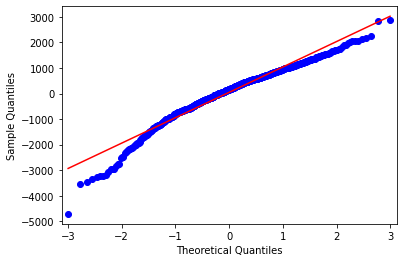

In [40]:
residuals = model_results.resid
from statsmodels.graphics.gofplots import qqplot
qqplot_data = qqplot(residuals, line='s').gca().lines

Ao olharmos o histograma dos resíduos, é possível perceber como a cauda à esquerda é mais longa, e como o centro da distribuição é mais alongado e alto que a distribuição teórica normal

In [41]:
fig = px.histogram(pd.DataFrame(residuals,columns=["residuals"]), x="residuals", height=300, width=500)
fig.update_layout(
    title={
        'text': "Histograma dos resíduos",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
        )
fig.show()

Uma das explicações possíveis para esse comportamento é que os resíduos só terão distribuição normal se as observações forem independentes entre si. Como apontado anteriormente, há uma quebra dessa expectativa, já que há uma tendência temporal de aumento da variável independente 'cnt' (contagem total de usuários).

## 2.4 Avaliação do modelo

Para avaliar de fato o modelo, escolhemos o método de validação cruzada, com frações de 20%, e com os dados embaralhados previamente. Como é possível ver com os resultados, tivemos um RMSE em torno de 945, o que representa 21% da média dos dados originais.

Nos gráficos boxplot abaixo, foi feito um teste com divisão de 20% dos dados para teste. É possível enxergar de forma mais visual como os resíduos se apresentam. 

In [42]:
#@title

from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#shuffling our dataframe
df_shuffled = df.sample(frac=1).reset_index(drop=True)

X = df_shuffled[['temp','yr','mnth','windspeed', 'hum', 'weathersit_num']]
y = df_shuffled[['cnt']]
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X, y, cv=5, scoring = 'neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
#print(scores)
print("MSE: %0.2f with a standard deviation of %0.2f" % (-1*scores.mean(), scores.std()))
print("RMSE: %0.2f with a standard deviation of %0.2f" % (rmse_scores.mean(), rmse_scores.std()))
print("Original data: %0.2f mean with a standard deviation of %0.2f" % (df['cnt'].mean(), df['cnt'].std()))
print("Mean RMSE found divided by original data mean: %0.2f" % (rmse_scores.mean()/df['cnt'].mean()))

MSE: 897650.98 with a standard deviation of 123284.03
RMSE: 945.13 with a standard deviation of 66.18
Original data: 4504.35 mean with a standard deviation of 1937.21
Mean RMSE found divided by original data mean: 0.21


In [43]:
#@title

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
y_pred = pd.Series(row[0] for row in y_pred)
y_test = y_test['cnt'].reset_index(drop=True)
errors = y_test-y_pred

fig = go.Figure()
fig.add_trace(go.Box(y=y_test, name = "Test data sample (20%)"))
fig.add_trace(go.Box(y=y_pred, name = "Model predictions for test data sample"))
fig.add_trace(go.Box(y=errors, name = "Residuals"))
fig.add_trace(go.Box(y=[abs(item) for item in errors], name = "Residuals (absolute values)"))
fig.update_layout(
    title={
        'text': "Boxplot para validação",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'middle'},
        showlegend = False
        )
fig.update_layout(margin = dict(l=0,r=0,b=30, t=50))
fig.update_layout(height=500, width=1000)
fig.show()


Olhando as top 10 previsões erradas, conseguimos perceber alguns dias que fogem do comum, como por exemplo dias próximos a natal e ano novo, e também dias com quantidades muito altas de usuários, bem acima do terceiro quartil.

In [44]:
#@title

test_df = X_test.reset_index(drop = True)
test_df['cnt'] = y_test
test_df['cnt_predicted'] = y_pred
test_df['residual'] = errors
test_df['residual_abs'] = [abs(item) for item in errors]

test_df.sort_values(by="residual_abs", ascending = False).head(10)

,temp,yr,mnth,windspeed,hum,weathersit_num,cnt,cnt_predicted,residual,residual_abs
94,0.440000,1,10,0.358200,0.880000,3,22,3938.816399,-3916.816399,3916.816399
3,0.822500,1,7,0.125629,0.573750,1,4672,7866.513684,-3194.513684,3194.513684
42,0.253333,1,12,0.124383,0.752917,2,1341,4356.634879,-3015.634879,3015.634879
99,0.849167,0,7,0.131221,0.500000,1,3285,6078.878905,-2793.878905,2793.878905
40,0.243333,1,12,0.316546,0.823333,3,441,3169.841023,-2728.841023,2728.841023
120,0.815833,1,7,0.168529,0.518750,1,5531,7766.333519,-2235.333519,2235.333519
41,0.396667,1,4,0.344546,0.835417,3,1027,3240.177061,-2213.177061,2213.177061
97,0.554167,1,10,0.268025,0.664167,1,7965,6105.631510,1859.368490,1859.368490
19,0.583333,1,6,0.186562,0.549167,1,8120,6264.868902,1855.131098,1855.131098
2,0.635833,1,8,0.086450,0.711667,2,4549,6336.050657,-1787.050657,1787.050657


In [45]:
for cnt_value in test_df.sort_values(by="residual_abs", ascending = False).head(10)['cnt'].values:
  print("________")
  print(df[df['cnt']==cnt_value][['cnt','dteday','season','workingday','weathersit']].T)

________
                               667
cnt                             22
dteday                  2012-10-29
season                    4_autumn
workingday                 workday
weathersit  3 _ Formations - Light
________
                   554
cnt               4672
dteday      2012-07-08
season        3_summer
workingday     restday
weathersit   1 _ Clear
________
                   728
cnt               1341
dteday      2012-12-29
season        1_winter
workingday     restday
weathersit    2 _ Mist
________
                   203
cnt               3285
dteday      2011-07-23
season        3_summer
workingday     restday
weathersit   1 _ Clear
________
                               725
cnt                            441
dteday                  2012-12-26
season                    1_winter
workingday                 workday
weathersit  3 _ Formations - Light
________
                   547
cnt               5531
dteday      2012-07-01
season        3_summer
workingday     restd

#3.Próximos passos

Como próximos passos, há outros modelos a serem avaliados, como a regressão polinomial a árvore de decisão e muitos outros. Foram levantados diversos pontos no documento sobre quais premissas da regressão linear não foram satisfeitas neste caso, e que portanto há a oportunidade de modelos diferentes trazerem melhores resultados.